In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

import healpy as hp
from matplotlib.colors import LogNorm
from scipy import stats

In [2]:
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'figure.facecolor': 'w'}
plt.rcParams.update(params)

In [13]:
nmad = lambda x: 1.4826 * np.median(np.abs(x-np.median(x)))

In [3]:
sweep_list = sorted(glob.glob('/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/north/sweep/9.0/*.fits'))
sweep_list = [os.path.basename(fn).replace('.fits', '') for fn in sweep_list]

gaia_stack = []
cat_stack = []
for sweep_fn in sweep_list:
    
    if not os.path.isfile('/global/cfs/cdirs/desi/users/rongpu/data/gaia_dr3/dr9_north_cross_match/'+sweep_fn+'-gaia.fits'):
        continue
    gaia = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/data/gaia_dr3/dr9_north_cross_match/'+sweep_fn+'-gaia.fits'))
    cat = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/data/gaia_dr3/dr9_north_cross_match/'+sweep_fn+'-ls.fits'))
    # print(len(gaia))

    mask = gaia['PHOT_G_MEAN_MAG']<17.65
    gaia = gaia[mask]
    cat = cat[mask]
    # print(len(gaia))

    # maskbits = [0, 2, 3, 4, 5, 6, 7, 10, 12, 13]
    maskbits = [0, 1, 10, 12, 13]
    mask_clean = np.ones(len(cat), dtype=bool)
    for bit in maskbits:
        mask_clean &= (cat['MASKBITS'] & 2**bit)==0
    # print(np.sum(~mask_clean)/len(mask_clean))
    gaia = gaia[mask_clean]
    cat = cat[mask_clean]
    # print(len(gaia))

    mask = (cat['FLUX_G']>0) & (cat['FLUX_R']>0) & (cat['FLUX_Z']>0)
    mask &= (cat['FLUX_IVAR_G']>0) & (cat['FLUX_IVAR_R']>0) & (cat['FLUX_IVAR_Z']>0)
    mask &= (cat['FRACFLUX_G']<0.1) & (cat['FRACFLUX_R']<0.1) & (cat['FRACFLUX_Z']<0.1)
    gaia = gaia[mask]
    cat = cat[mask]
    # print(len(gaia))
    
    gaia_stack.append(gaia)
    cat_stack.append(cat)
    # print()

gaia = vstack(gaia_stack)
cat = vstack(cat_stack)

In [4]:
print(len(cat))

6344979


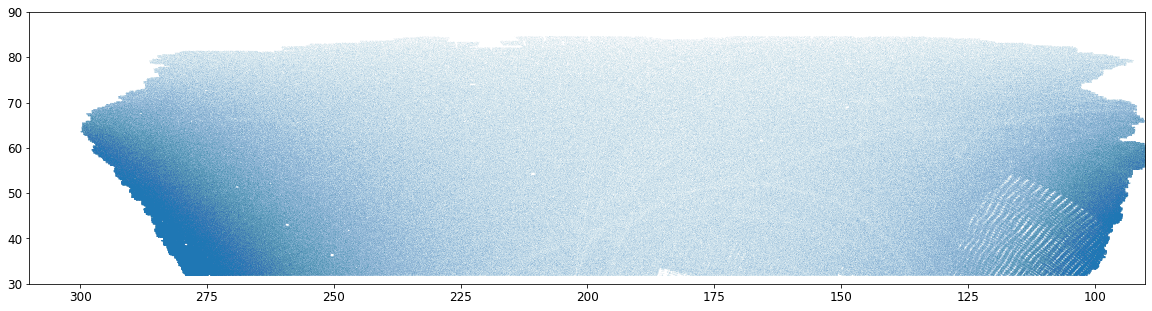

In [5]:
plt.figure(figsize=(20, 5))
plt.plot(cat['RA'], cat['DEC'], '.', ms=0.1, alpha=0.1)
plt.axis([310, 90, 30, 90])
plt.show()

In [6]:
# Random downsampling to speed up calculations
idx = np.sort(np.random.choice(len(cat), size=len(cat)//10, replace=False))
gaia = gaia[idx]
cat = cat[idx]
print(len(cat))

634497


In [7]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cat['gmag'] = 22.5 - 2.5*np.log10(cat['FLUX_G'])
    cat['rmag'] = 22.5 - 2.5*np.log10(cat['FLUX_R'])
    cat['zmag'] = 22.5 - 2.5*np.log10(cat['FLUX_Z'])
    gaia['gmag'] = 22.5 - 2.5*np.log10(gaia['flux_g'])
    gaia['rmag'] = 22.5 - 2.5*np.log10(gaia['flux_r'])
    gaia['zmag'] = 22.5 - 2.5*np.log10(gaia['flux_z'])

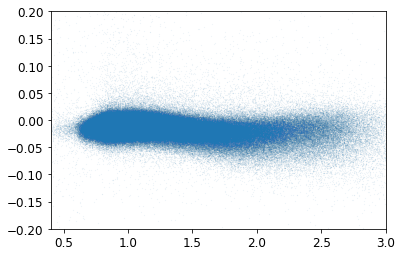

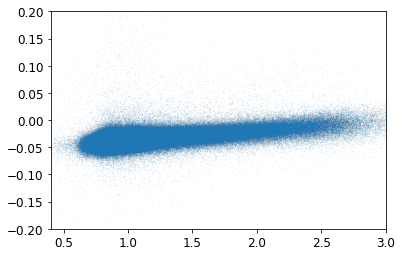

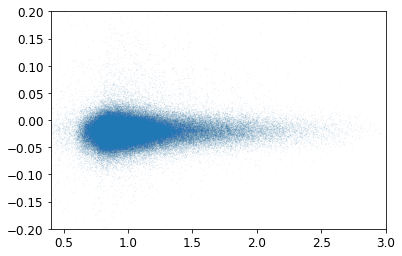

In [8]:
mask = (cat['ANYMASK_G']==0)
plt.plot(gaia['PHOT_BP_MEAN_MAG'][mask]-gaia['PHOT_RP_MEAN_MAG'][mask], (cat['gmag']-gaia['gmag'])[mask], '.', ms=00.1, alpha=0.5)
plt.axis([0.4, 3., -0.2, 0.2])
plt.show()

mask = (cat['ANYMASK_R']==0)
plt.plot(gaia['PHOT_BP_MEAN_MAG'][mask]-gaia['PHOT_RP_MEAN_MAG'][mask], (cat['rmag']-gaia['rmag'])[mask], '.', ms=00.1, alpha=0.5)
plt.axis([0.4, 3., -0.2, 0.2])
plt.show()

mask = (cat['ANYMASK_Z']==0)
plt.plot(gaia['PHOT_BP_MEAN_MAG'][mask]-gaia['PHOT_RP_MEAN_MAG'][mask], (cat['zmag']-gaia['zmag'])[mask], '.', ms=00.1, alpha=0.5)
plt.axis([0.4, 3., -0.2, 0.2])
plt.show()

In [9]:
import statsmodels.api as sm

def rlm_fit1d(x, y, t=1.5, order=1):
    '''
    1D robust polynomial fit.
    
    Given x array and y array, calculate the 1D robust 
    polynomial fit of arbitrary order. Huber weight
    function is used. 
    
    See also poly_val1d.py
    
    INPUT:
    1D arrays of x and y values; tunning parameter t; 
    order of the polynomial fit.
    
    OUTPUT:
    Array of parameters of the polynomial [a0, a1, a2 ...] 
    so that y = a0 + a1*x + a2*x**2 + ...
    '''
    
    ncols = order+1
    a = np.zeros((x.size,ncols))
    for i in range(order+1):
        a[:,i] = x**i
    res = sm.RLM(y, a, M=sm.robust.norms.HuberT(t=t)).fit()
    m = res.params
    return(m)

def poly_val1d(x, m):
    '''
    Evaluate the 1D polynomial from x values and polynomial parameters
    
    See also rlm_fit1d.py
    
    INPUT:
    1D array of x values; 
    1D array of polynomial parameters (for example generated by 
    rlm_fit1d.py).
    
    OUTPUT:
    1D array of the evaluated values of the polynomial.
    '''
    
    order = len(m)-1
    z = np.zeros(x.shape)
    for i in range(order+1):
        z += m[i] * x**i
    return z

__Iterate__

In [16]:
# Initial parameters
coeffs_bprp = {'g': np.array([-0.0424541187, -0.0048023503, 0.1722044513, -0.2096294576,
        0.0881678633, -0.0123851305]),
 'r': np.array([-0.1197585865, 0.2359457162, -0.2685339639, 0.1552435667,
        -0.0427155557, 0.0045126191]),
 'z': np.array([-0.0390049790, 0.0423094017, -0.0305986442, 0.0063608670,
        0.0014287625, -0.0004802459])}

coeffs_g = {'g': np.array([53.0584557291, -15.4824166173, 1.8163914666, -0.1070887106,
        0.0031742305, -0.0000378809]),
 'r': np.array([678.9220979698, -176.8009800679, 18.0040476887, -0.8885167812,
        0.0209419286, -0.0001833166]),
 'z': np.array([1730.7098724952, -365.4114635309, 25.8676588686, -0.5020273271,
        -0.0155625926, 0.0005435736])}

for band in ['g', 'r', 'z']:
    bprp = (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])
    gaia_g = gaia['PHOT_G_MEAN_MAG'].copy()
    gaia[band+'_std_bprp'] = poly_val1d(bprp, coeffs_bprp[band])
    gaia[band+'_std_g'] = poly_val1d(gaia_g, coeffs_g[band])

In [17]:
coeffs_bprp = {}

for band in ['g', 'r', 'z']:
    mask = (cat['ANYMASK_'+band.upper()]==0)
    mask &= (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])>0.5
    mask &= (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])<3.0
    bprp = (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])[mask]
    if band+'_std_g' in gaia.colnames:
        dmag = (cat[band+'mag']-(gaia[band+'mag']+gaia[band+'_std_g']))[mask]
    else:
        dmag = (cat[band+'mag']-gaia[band+'mag'])[mask]
    poly_order = 5
    coeffs_bprp[band] = rlm_fit1d(bprp, dmag, t=0.02, order=poly_order)
    print(band)
    print(coeffs_bprp[band])

np.set_printoptions(precision=5)
float_formatter = "{:.10f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

coeffs_bprp

g
[-0.0269569852 -0.0569120152 0.2388830858 -0.2504472232 0.1000919830
 -0.0137063995]
r
[-0.1041775478 0.1725203068 -0.1785268995 0.0978524249 -0.0257074158
 0.0026038758]
z
[-0.0346933448 0.0201737358 0.0054241207 -0.0188843628 0.0096540027
 -0.0014980102]


{'g': array([-0.0269569852, -0.0569120152, 0.2388830858, -0.2504472232,
        0.1000919830, -0.0137063995]),
 'r': array([-0.1041775478, 0.1725203068, -0.1785268995, 0.0978524249,
        -0.0257074158, 0.0026038758]),
 'z': array([-0.0346933448, 0.0201737358, 0.0054241207, -0.0188843628,
        0.0096540027, -0.0014980102])}

In [18]:
coeffs_g = {}

for band in ['g', 'r', 'z']:
    bprp = (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])
    gaia[band+'mag_std'] = gaia[band+'mag'] + poly_val1d(bprp, coeffs_bprp[band])
    mask = (cat['ANYMASK_'+band.upper()]==0)
    mask &= (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])>0.6
    mask &= (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])<2.5
    mask &= gaia['PHOT_G_MEAN_MAG']>13.5
    mask &= gaia['PHOT_G_MEAN_MAG']<17.65
    gaia_g = (gaia['PHOT_G_MEAN_MAG'])[mask]
    dmag = (cat[band+'mag']-gaia[band+'mag_std'])[mask]
    poly_order = 5
    coeffs_g[band] = rlm_fit1d(gaia_g, dmag, t=0.02, order=poly_order)
    print(band)
    print(coeffs_g[band])

np.set_printoptions(precision=5)
float_formatter = "{:.10f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

coeffs_g

g
[44.7394180505 -12.9950765935 1.5190853966 -0.0893304621 0.0026441633
 -0.0000315555]
r
[667.0475676882 -173.0837779218 17.5399967510 -0.8596327177 0.0200454174
 -0.0001722149]
z
[1727.9720400353 -364.5131062097 25.7499690378 -0.4943381013 -0.0158129562
 0.0005468214]


{'g': array([44.7394180505, -12.9950765935, 1.5190853966, -0.0893304621,
        0.0026441633, -0.0000315555]),
 'r': array([667.0475676882, -173.0837779218, 17.5399967510, -0.8596327177,
        0.0200454174, -0.0001722149]),
 'z': array([1727.9720400353, -364.5131062097, 25.7499690378, -0.4943381013,
        -0.0158129562, 0.0005468214])}

In [10]:
coeffs_bprp = {'g': np.array([-0.0269569852, -0.0569120152, 0.2388830858, -0.2504472232,
        0.1000919830, -0.0137063995]),
 'r': np.array([-0.1041775478, 0.1725203068, -0.1785268995, 0.0978524249,
        -0.0257074158, 0.0026038758]),
 'z': np.array([-0.0346933448, 0.0201737358, 0.0054241207, -0.0188843628,
        0.0096540027, -0.0014980102])}

coeffs_g = {'g': np.array([44.7394180505, -12.9950765935, 1.5190853966, -0.0893304621,
        0.0026441633, -0.0000315555]),
 'r': np.array([667.0475676882, -173.0837779218, 17.5399967510, -0.8596327177,
        0.0200454174, -0.0001722149]),
 'z': np.array([1727.9720400353, -364.5131062097, 25.7499690378, -0.4943381013,
        -0.0158129562, 0.0005468214])}

In [11]:
for band in ['g', 'r', 'z']:
    bprp = (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])
    gaia_g = gaia['PHOT_G_MEAN_MAG'].copy()
    gaia[band+'mag_std'] = gaia[band+'mag'] + poly_val1d(bprp, coeffs_bprp[band])
    gaia[band+'mag_std'] += poly_val1d(gaia_g, coeffs_g[band])

g NMAD unstandardized: 0.01428 442558 0.6974942355913424
g NMAD   standardized: 0.01214
r NMAD unstandardized: 0.01356 345612 0.5447023390181513
r NMAD   standardized: 0.01031
z NMAD unstandardized: 0.01803 136917 0.21578825431798732
z NMAD   standardized: 0.01801


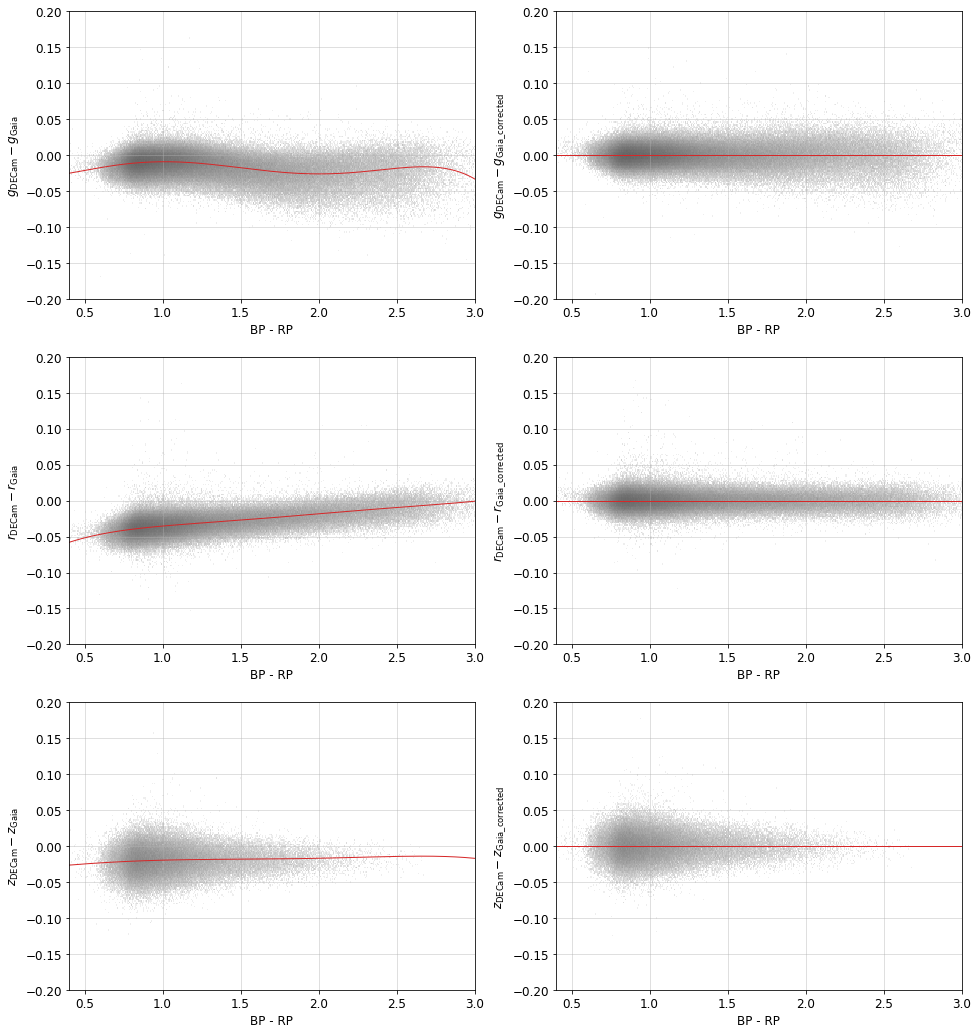

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

for index, band in enumerate(['g', 'r', 'z']):
    mask = (cat['ANYMASK_'+band.upper()]==0)
    bprp = (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])[mask]
    dmag = (cat[band+'mag']-gaia[band+'mag'])[mask]
    mask = np.isfinite(dmag)
    bprp, dmag = bprp[mask], dmag[mask]
    print(band, 'NMAD unstandardized: {:.5f};  '.format(nmad(dmag)), np.sum(mask), np.sum(mask)/len(cat))

    y_predict = poly_val1d(bprp, coeffs_bprp[band])
    x_plot = np.linspace(0, 4, 200)
    y_plot = poly_val1d(x_plot, coeffs_bprp[band])

    xbins, ybins = np.linspace(0.4, 3., 400), np.linspace(-0.2, 0.2, 200)
    xbins1 = np.linspace(0.4, 3., 100)
    ax = axes[index, 0]
    ax.hist2d(bprp, dmag, bins=[xbins, ybins], cmap='gray_r', norm=LogNorm(vmin=1, vmax=20000))
    ax.plot(x_plot, y_plot, '-', lw=1., color='C3')
    # bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    # bin_median, bin_edges, _ = stats.binned_statistic(bprp, dmag, statistic='median', bins=xbins1)
    # bin_16, _, _ = stats.binned_statistic(bprp, dmag, statistic=lambda dmag: np.percentile(dmag, 15.9), bins=xbins1)
    # bin_84, _, _ = stats.binned_statistic(bprp, dmag, statistic=lambda dmag: np.percentile(dmag, 84.1), bins=xbins1)
    # bin_5, _, _ = stats.binned_statistic(bprp, dmag, statistic=lambda dmag: np.percentile(dmag, 5), bins=xbins1)
    # bin_95, _, _ = stats.binned_statistic(bprp, dmag, statistic=lambda dmag: np.percentile(dmag, 95), bins=xbins1)
    # ax.plot(bin_centers, bin_median, 'C1--', lw=1., label='median')
    # ax.plot(bin_centers, bin_16, 'C1--', lw=1., label='5th, 16th, 84th, 95th percentiles')
    # ax.plot(bin_centers, bin_84, 'C1--', lw=1.)
    # ax.plot(bin_centers, bin_5, 'C1--', lw=1.)
    # ax.plot(bin_centers, bin_95, 'C1--', lw=1.)
    ax.set_xlabel('BP - RP')
    ylabel = '$'+band+'_\mathrm{DECam} - '+band+'_\mathrm{Gaia}$'
    ax.set_ylabel(ylabel)
    ax.axis([0.4, 3., -0.2, 0.2])
    ax.grid(alpha=0.5)
    # if index==0:
    #     ax.legend(loc='upper right')

    mask = (cat['ANYMASK_'+band.upper()]==0)
    gaia_g = (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG'])[mask]
    dmag = (cat[band+'mag']-gaia[band+'mag_std'])[mask]
    mask = np.isfinite(dmag)
    gaia_g, dmag = gaia_g[mask], dmag[mask]
    print(band, 'NMAD   standardized: {:.5f}'.format(nmad(dmag)))

    ax = axes[index, 1]
    ax.hist2d(gaia_g, dmag, bins=[xbins, ybins], cmap='gray_r', norm=LogNorm(vmin=1, vmax=20000))
    ax.axhline(0, lw=1, color='C3', ls='-')
    # bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    # bin_median, bin_edges, _ = stats.binned_statistic(gaia_g, dmag-y_predict, statistic='median', bins=xbins1)
    # bin_16, _, _ = stats.binned_statistic(gaia_g, dmag-y_predict, statistic=lambda dmag: np.percentile(dmag, 15.9), bins=xbins1)
    # bin_84, _, _ = stats.binned_statistic(gaia_g, dmag-y_predict, statistic=lambda dmag: np.percentile(dmag, 84.1), bins=xbins1)
    # bin_5, _, _ = stats.binned_statistic(gaia_g, dmag-y_predict, statistic=lambda dmag: np.percentile(dmag, 5), bins=xbins1)
    # bin_95, _, _ = stats.binned_statistic(gaia_g, dmag-y_predict, statistic=lambda dmag: np.percentile(dmag, 95), bins=xbins1)
    # ax.plot(bin_centers, bin_median, 'C1:', lw=1.)
    # ax.plot(bin_centers, bin_16, 'C1--', lw=1.)
    # ax.plot(bin_centers, bin_84, 'C1--', lw=1.)
    # ax.plot(bin_centers, bin_5, 'C1--', lw=1.)
    # ax.plot(bin_centers, bin_95, 'C1--', lw=1.)
    ax.set_xlabel('BP - RP')
    ylabel = '$'+band+'_\mathrm{DECam} - '+band+'_\mathrm{Gaia\_corrected}$'
    ax.set_ylabel(ylabel)
    ax.axis([0.4, 3., -0.2, 0.2])
    ax.grid(alpha=0.5)
plt.show()

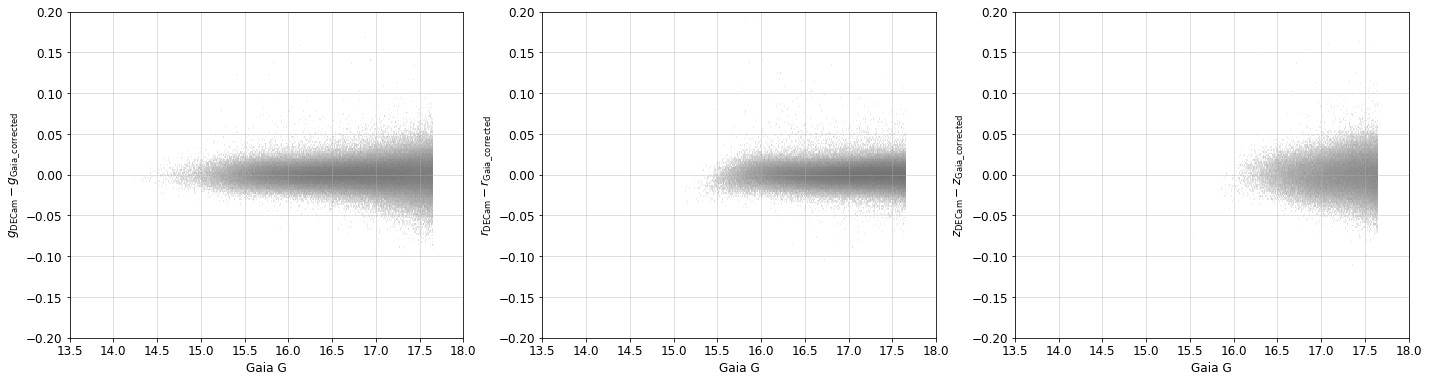

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
for index, band in enumerate(['g', 'r', 'z']):
    mask = (cat['ANYMASK_'+band.upper()]==0)
    mask &= (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG']) > 0.6
    mask &= (gaia['PHOT_BP_MEAN_MAG']-gaia['PHOT_RP_MEAN_MAG']) < 2.5
    gaia_g = gaia['PHOT_G_MEAN_MAG'][mask].copy()
    dmag = (cat[band+'mag']-gaia[band+'mag_std'])[mask]
    mask = np.isfinite(dmag)
    gaia_g, dmag = gaia_g[mask], dmag[mask]
    xbins, ybins = np.linspace(13.5, 18, 400), np.linspace(-0.2, 0.2, 200)
    xbins1 = np.linspace(13.5, 18, 100)
    ax = axes[index]
    ax.hist2d(gaia_g, dmag, bins=[xbins, ybins], cmap='gray_r', norm=LogNorm(vmin=1, vmax=20000))
    # bin_median, bin_edges, _ = stats.binned_statistic(gaia_g, dmag, statistic='median', bins=xbins1)
    # bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    # bin_16, _, _ = stats.binned_statistic(gaia_g, dmag, statistic=lambda dmag: np.percentile(dmag, 15.9), bins=xbins1)
    # bin_84, _, _ = stats.binned_statistic(gaia_g, dmag, statistic=lambda dmag: np.percentile(dmag, 84.1), bins=xbins1)
    # bin_5, _, _ = stats.binned_statistic(gaia_g, dmag, statistic=lambda dmag: np.percentile(dmag, 5), bins=xbins1)
    # bin_95, _, _ = stats.binned_statistic(gaia_g, dmag, statistic=lambda dmag: np.percentile(dmag, 95), bins=xbins1)
    # bin_count, _ = np.histogram(gaia_g, bins=xbins1)
    # mask = bin_count>200
    # ax.plot(bin_centers[mask], bin_median[mask], 'C1:', lw=1., label='median')
    # ax.plot(bin_centers[mask], bin_16[mask], 'C1--', lw=1., label='5th, 16th, 84th, 95th percentiles')
    # ax.plot(bin_centers[mask], bin_84[mask], 'C1--', lw=1.)
    # ax.plot(bin_centers[mask], bin_5[mask], 'C1--', lw=1.)
    # ax.plot(bin_centers[mask], bin_95[mask], 'C1--', lw=1.)
    ax.set_xlabel('Gaia G')
    ylabel = '$'+band+'_\mathrm{DECam} - '+band+'_\mathrm{Gaia\_corrected}$'
    ax.set_ylabel(ylabel)
    ax.axis([13.5, 18, -0.2, 0.2])
    ax.grid(alpha=0.5)
    # if index==0:
    #     ax.legend(loc='lower left')
plt.show()